<a href="https://colab.research.google.com/github/satishchaudhary382/RFM/blob/master/wma%2Bchart%2Bbacktest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [299]:
import pandas as pd
import numpy as np
import altair as alt
from vega_datasets import data
import matplotlib.pyplot as plt

df = pd.read_csv("/content/SICL.csv", parse_dates=['Date'])
df.rename({'LTP':'Close'}, inplace = True, axis = 1)
df.sort_values(by='Date',ascending=True, inplace = True)
df = df[['Date','Open','High','Low','Close']]
df.head()


,Date,Open,High,Low,Close
0,2012-08-30,307.0,324.0,312.0,324.0
1,2012-09-02,324.0,334.0,322.0,322.0
2,2012-09-03,322.0,325.0,316.0,322.0
3,2012-09-04,322.0,328.0,322.0,328.0
4,2012-09-05,328.0,322.0,322.0,322.0


In [300]:
# source = data.ohlc()


In [301]:
def Hanning(size):
    w = np.hanning(size+2)
    w = np.array(w[1:-1])  # remove zeros at endpoints
    return (w / max(w))

def wma(fs, size, pad=True, winType=Hanning, wts=None):
    """Apply a weighted moving average on the supplied series.
    Parameters
    ----------
    s : pandas.Series
        data to be averaged
    size : integer
        how wide a window to use
    pad : Boolean (optional, default = True)
        flag determining whether to pad beginning and end of data with a
        weighted average of the last `size` points. This provides better
        smoothing at the beginning and end of the line, but it tends to have
        zero slope.
    winType : Function (optional, default = Hanning)
        Window function that takes an integer (window size) and returns a list
        of weights to be applied to the data. The default is Hanning, a
        weighted cosine with non-zero endpoints. Other possible windows are:
        * np.bartlett (triangular with endpoints of 0)
        * np.blackman (3 cosines creating taper)
        * np.hamming (weighted cosine)
        * np.hanning (weighted cosine with endpoints of 0)
        * Triangle (triangle with non-zero enpoints, and option to
                    clip top of triangle)
    wts : list (optional, default = None)
        List of weights to use. `size` becomes the length of wts. Use this
        option to provide a custom weighting function. The length of wts
        should be odd, but this is not enforced.
    Returns
    -------
    Pandas Series containing smoothed data
    Notes
    -----
    Defaults to using a Hanning window for weights, centered on
    each point. For points near the beginning or end of data, special
    processing is required that isn't in built-in functions.
    Any rows with no value (nan) are dropped from series, and that reduced
    series is returned. This series will have fewer members than what was
    given, and may cause problems with mismatched indexes.
    """
    def SetLimits(i, hw):
        # i: current data location where window is centred
        # hw: half window width
        ds = max(0, (i-hw))         # data start
        de = min(n-1, (i+hw)) # data end
        ws = hw - (i - ds)          # window start
        we = hw + (de - i)          # window end
        return ds, de, ws, we

    s = fs.dropna()
    if type(wts) == type(None):
        size += (size+1) % 2  # make odd
        window = winType(size)
        window /= window.sum()  # normalize window
    else:
        window = wts / wts.sum()
        size = len(wts)
    n = len(s)
    hw = int(size / 2) # half window width
    # convolve has boundary effects when there is no overlap with the window
    # Begining and end of 'a' must be adjusted to compensate.
    # np.average() effectively scales the weights for the different sizes.
    if pad: # pad the data with reflected values
        # create padded beginning
        y = np.zeros(n+2*hw)
        for i in range(hw):
            y[i] = s.iloc[hw-i]
        for i in range(hw):
            y[i+n+hw] = s.iloc[n-i-1]
        for i in range(n):
            y[i+hw] = s.iloc[i]
        yc = np.convolve(y, window, mode='same')
        a = pd.Series(yc[hw:n+hw],
                      index=s.index,
                      name=s.name)
    else: # clip window as available data decreases
        a = pd.Series(np.convolve(s, window, mode='same'),
                      index=s.index,
                      name=s.name)
        for i in range(hw+1):  # fix the start
            (ds, de, ws, we) = SetLimits(i, hw)
            a.iloc[i] = np.average(s.iloc[ds:de], weights=window[ws:we])
        for i in range(n-hw-1, n):  # fix the end
            (ds, de, ws, we) = SetLimits(i, hw)
            a.iloc[i] = np.average(s.iloc[ds:de], weights=window[ws:we])
    return a

In [302]:
import pandas_datareader as pdr
# source = pdr.get_data_yahoo("AAPL","1/1/2019","6/1/2020")
source = df
# source.reset_index(inplace = True)

In [303]:
import numpy as np
source['wma1'] = wma(source.Close,30)
source['wma2'] = wma(source.Close.shift(2),30)

In [304]:
import ta
adx = ta.trend.ADXIndicator(source.High, source.Low, source.Close,21)
source['ADX'] = adx.adx()
source['POS'] = adx.adx_pos()
source['NEG'] = adx.adx_neg()
# source = source.iloc[200:]
source['POS1']  = wma(source['POS'],30)
source['POS2'] =  wma(source['POS'].shift(4),30)

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [305]:

open_close_color = alt.condition("datum.wma1>= datum.wma2",
                                 alt.value("#06982d"),
                                 alt.value("#ae1324"))

base = alt.Chart(source).encode(
    alt.X('Date:T',
          axis=alt.Axis(
              format='%m/%d',
              labelAngle=-45,
              title='Date'
          )
    ),
    color=open_close_color
).properties(
    width=9000,
    height=500
)

rule = base.mark_rule().encode(
    alt.Y(
        'Low:Q',
        title='Price',
        scale=alt.Scale(zero=False),
    ),
    alt.Y2('High:Q')
)

bar = base.mark_bar().encode(
    alt.Y('Open:Q'),
    alt.Y2('Close:Q')
)

rule + bar

alt.LayerChart(...)

In [306]:
source['Diff'] = source.wma1 - source.wma2

In [307]:
import altair as alt
from vega_datasets import data



bar = alt.Chart(source).mark_bar().encode(
    x='Date:T',
    y='Diff:Q')
# rule = alt.Chart(source).mark_rule(color='red').encode(
#     y='mean(wheat):Q'
# )

(bar).properties(width=6000)

alt.Chart(...)

In [308]:
def signal(source):
  if source.wma1>source.wma2:
    return 1
  else:
    return -1
source['Signal'] = source.apply(signal, axis=1)
source.set_index('Date',inplace = True)

In [309]:
source['S'] = (source['Signal']-source['Signal'].shift(1))

In [316]:
initial_capital = 30000
initial = 0
buy = 0
b = 0

r = []
for i in range(len(source)):
  if source['S'][i] == 2:
    buy_unit = initial_capital//source.Close[i]
    buy += buy_unit
    initial = initial_capital - (buy_unit * source.Close[i])
    initial_capital -= initial
    b += source.Close[i]
    d = (source.index[i])
    print(f"Stock was bought on {source.index[i]} at {source.Close[i]}. Unit in stock {buy}. Remaining amount {initial}") 
  elif (source['S'][i] == -2) and (buy >0):
    sell = buy * source.Close[i] 
    buy = 0
    net = initial + (sell* source.Close[i])
    print(f"Stock was sold on {source.index[i]} at {source.Close[i]}. Return {np.round(source.Close[i]/b,3)}. Time {source.index[i] - d}")
    r.append(source.Close[i]/b)
    b= 0
    d=0

Stock was bought on 2012-09-03 00:00:00 at 322.0. Unit in stock 93.0. Remaining amount 54.0
Stock was sold on 2013-02-26 00:00:00 at 542.0. Return 1.683. Time 176 days 00:00:00
Stock was bought on 2013-04-29 00:00:00 at 429.0. Unit in stock 69.0. Remaining amount 345.0
Stock was sold on 2013-05-27 00:00:00 at 547.0. Return 1.275. Time 28 days 00:00:00
Stock was bought on 2013-07-15 00:00:00 at 406.0. Unit in stock 72.0. Remaining amount 369.0
Stock was sold on 2013-09-04 00:00:00 at 511.0. Return 1.259. Time 51 days 00:00:00
Stock was bought on 2013-09-19 00:00:00 at 525.0. Unit in stock 55.0. Remaining amount 357.0
Stock was sold on 2014-03-06 00:00:00 at 1155.0. Return 2.2. Time 168 days 00:00:00
Stock was bought on 2014-05-15 00:00:00 at 900.0. Unit in stock 32.0. Remaining amount 75.0
Stock was sold on 2014-05-28 00:00:00 at 960.0. Return 1.067. Time 13 days 00:00:00
Stock was bought on 2014-06-23 00:00:00 at 855.0. Unit in stock 33.0. Remaining amount 585.0
Stock was sold on 2014-

In [318]:
a = 10000
portfolio = []
for i in r:
  b = a*i
  a += ((b-a)*0.95)
  portfolio.append(a)
  print(a)

16490.68322981366
20799.787169352385
25910.07970665017
55447.57057223136
58959.25004180601
64527.62365686546
79149.10519511372
91509.37641736436
156253.86004692267
328742.1345420822
636391.2387772498
708578.9016833258
913450.6276048091
1196077.944070659
1338871.7414042284
1584112.790769284
1687439.7491040686
2008053.3014338417
2049858.7940415475
2123554.978896138
2215612.6099890927
3820992.933328647
5768211.2541889055


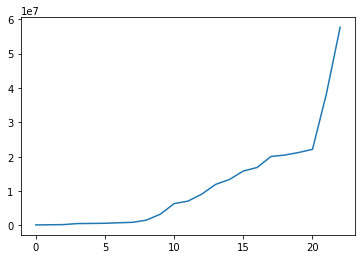

In [313]:
plt.plot(portfolio)